# Advanced Lane Finding


In this project, the goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

## Import Packages

In [1]:
#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib qt

In [2]:

%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:9999;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

##### Helper Functions

In [3]:
# Helper Functions
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2)

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

There are two main steps to this process: `Calibrate` uses chessboard images to obtain image points and object points, and then use the OpenCV functions cv2.calibrateCamera() and cv2.undistort() to compute the calibration and undistortion.


In [4]:
class Camera(object):

    def __init__(self):
        # Calibration Matrix
        self.matrix = None
        
        # Distortion coefficients
        self.dist = None
        
        # Calibrated and failed images list
        self.calibrated_images = []
        self.failed_images = []

    def __call__(self, image):
        return self.undistorted_image(image)
        
    def undistorted_image(self, image):
        '''Returns undistorted image if camera is calibrated'''
        if self.matrix is not None and self.dist is not None:
            return cv2.undistort(image, self.matrix, self.dist, None, self.matrix)
        else:
            print('Caution! Camera is not calibrated')
            return image
        
    def calibrate(self, images, pattern_size):
        '''Calibration Process'''
        pattern = np.zeros((pattern_size[1] * pattern_size[0], 3), np.float32)
        pattern[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
        pattern_points = [] # points in real world image
        image_points = []   # points in image plane

        # Loop through the images looking for chessboard corners
        for image_path in images:
            image = mpimg.imread(image_path)
            
            # convert to grayscale
            gray = self.convert_to_grayscale(image)
            
            # find the chessboard corners
            f, corners = self.find_chessboard_corners(gray, pattern_size)
            # when corners found add object and image points
            if f:
                pattern_points.append(pattern)
                image_points.append(corners)
                # draw corners
                cv2.drawChessboardCorners(image, pattern_size, corners, True)
                self.calibrated_images.append(image)
            else:
                self.failed_images.append(image)

        self.calibrate_camera(image, pattern_points, image_points)

            
    @staticmethod
    def convert_to_grayscale(image):
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    @staticmethod    
    def find_chessboard_corners(image, pattern_size):
        return cv2.findChessboardCorners(image, pattern_size, None)
    
    def calibrate_camera(self, image, pattern_points, image_points):
        image_size = (image.shape[1], image.shape[0])
        if pattern_points and image_points:
            _, self.matrix, self.dist, _, _ = cv2.calibrateCamera(
            pattern_points, image_points, image_size, None, None)      


### Apply distortion correction

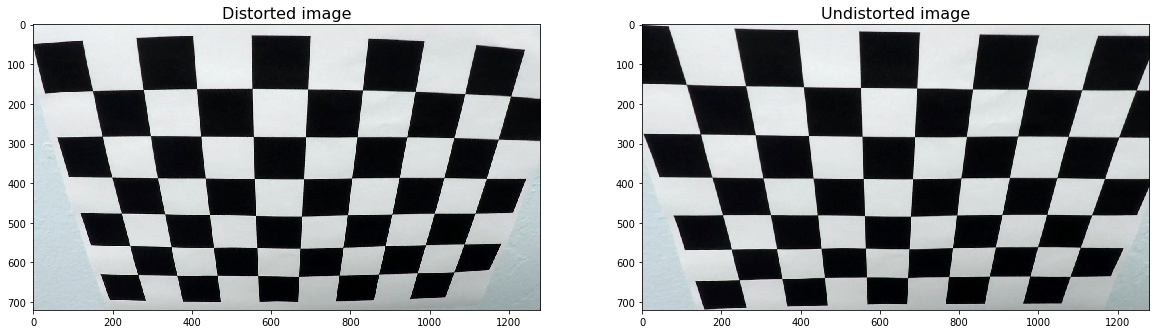

In [5]:
# Initialize Camera Object
camera = Camera()

# Calibrate Camera
camera.calibrate(glob.glob('camera_cal/*'), pattern_size=(9,6))

# Undistort test image
#for path in glob.glob('./test_images/*'):
for path in glob.glob('./camera_cal/calibration2.jpg'):
    img = cv2.imread(path)
    undistorted_img = camera(img)
    plt_images(img, 'Distorted image', undistorted_img, 'Undistorted image')




### Use color transforms, gradients, etc., to create a thresholded binary image.

In [6]:
class ImageTransformation(object):
    
    def __init__(self, color_space='gray'):
        # Calibration Matrix
        self.color_space = color_space
        
    # Combined ----------------------------------------------------------        
    def combined_binary(self, img):
        '''Combines the gradient masks and the color mask to one binary output'''
        color_mask = self.color_thresh(img)
        gradient_mask = self.gradient_thresh(img)
        
        mask = np.zeros_like(color_mask)
        mask[(gradient_mask == 1) | (color_mask == 1)] = 1
        return mask

    def combined_stacked(self, img):
        '''
        Stack each channel to view their individual contributions in green and blue respectively
        This returns a stack of the two binary images, whose components you can see as different colors'''
        color_mask = self.color_thresh(img)
        gradient_mask = self.gradient_thresh(img)
        img_hls_s = self.color_space_tf(img)
        
        return np.dstack((np.zeros_like(img_hls_s), gradient_mask, color_mask))
    
    def gradient_thresh(self, image):      
        '''Apply each of the thresholding functions and combines them to one binary output
        input img is image in standart color space'''
        
        # Gradient in x direction
        grad_x = self.abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
        # Gradient in y direction
        grad_y = self.abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
        # Gradient magnitude
        mag_binary = self.mag_thresh(image, sobel_kernel=ksize, thresh=(30, 100))
        # Gradient direction
        dir_binary = self.dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

        # Combine all of them
        gradient_mask = np.zeros_like(gradx)
        gradient_mask[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        
        return gradient_mask

    # Color Thresholds ------------------------------------------------------------------------

    def color_thresh(self, img, thresh=(170, 255)):
        '''Compute the color threshold in defined color space
        input img is image in standart color space'''
        img_hls_s = self.color_space_tf(img)
        color_mask = self.binary_output(img_hls_s, threshold=(170, 255))
        return color_mask
    
    # Gradient Thresholds ------------------------------------------------------------------------

    def abs_sobel_thresh(self, img, orient='x', sobel_kernel=3, thresh=(0, 255)):
        '''
        Applies Sobel x or y to the image in selected colorspace, 
        then takes an absolute value and applies a threshold.
        '''
        # Convert to selected colorspace - set at init
        image = self.color_space_tf(img, color_space=self.color_space)
        
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        sobelx, sobely = self.sobel_gradients(image, sobel_kernel)
        if orient == 'x':
            abs_sobel = np.absolute(sobelx)
        if orient == 'y':
            abs_sobel = np.absolute(sobely)
       
        # Create a copy and apply the threshold
        binary_output = self.binary_output(abs_sobel, thresh)

        # Return the result
        return binary_output

    def mag_thresh(self, img, sobel_kernel=3, thresh=(0, 255)):
        '''
        Applies Sobel x and y to the image in selected colorspace, 
        then computes the magnitude of the gradient and applies a threshold
        '''
        # Convert to selected colorspace - set at init
        image = self.color_space_tf(img, color_space=self.color_space)
        
        # Take both Sobel x and y gradients
        sobelx, sobely = self.sobel_gradients(image, sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)

        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = self.binary_output(gradmag, thresh)
        
        # Return the binary image
        return binary_output

    def dir_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):
        '''
        Applies Sobel x and y to the image in selected colorspace,
        then computes the direction of the gradient and applies a threshold.
        '''
        # Convert to selected colorspace - set at init
        image = self.color_space_tf(img, color_space=self.color_space)
        
        # Calculate the x and y gradients
        sobelx, sobely = self.sobel_gradients(image, sobel_kernel)
        # Take the absolute value of the gradient direction
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

        # Apply a threshold, and create a binary image result
        binary_output = self.binary_output(absgraddir, thresh)

        # Return the binary image
        return binary_output
    
    def binary_output(self, image, threshold):
        '''This method creates a binary image, scaled to 8bit for given thresholds'''
        # Scale back to 8bit
        img = self.scale_to_8bit(image)
        # Create a binary image
        # Mask with 1's where the gradient magnitude is between thresholds
        binary_output = np.zeros_like(img)
        binary_output[(img >= threshold[0]) & (img <= threshold[1])] = 1
        return binary_output
    
    @staticmethod
    def scale_to_8bit(image):
        '''This method scales the input image back to 8bit'''
        img  = np.uint8(255*image / np.max(image))
        return img
    
    @staticmethod
    def sobel_gradients(image, sobel_kernel=3):
        '''Calculate the x and y gradients'''
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        return sobelx, sobely
    
    # Color Space transformations ---------------------------------------------------------------------

    def color_space_tf(self, img, color_space='hls_s'):
        '''Transform image to defined color space picked at initialisation'''
        if color_space is 'gray':
            return self.transform_to_gray_channel(img)
        elif color_space is 'hls_s':
            return self.transform_to_hls_s_channel(img)
    
    @staticmethod
    def transform_to_hls_s_channel(img):
        '''Transform input image to HLS Space and pcik s channel'''
        # Convert to HLS space
        hls = cv2.cvtColor(np.copy(img), cv2.COLOR_RGB2HLS).astype(np.float)
        # Separate and get the S channel
        s = hls[:, :, 2]
        return s
    
    @staticmethod
    def transform_to_gray_channel(img):
        '''Transform image to grayscale'''
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    

The final image color_binary is a combination of binary thresholding the S channel (HLS) and binary thresholding the result of applying the Sobel operator in the x direction on the original image.

Transformation to color space type: gray


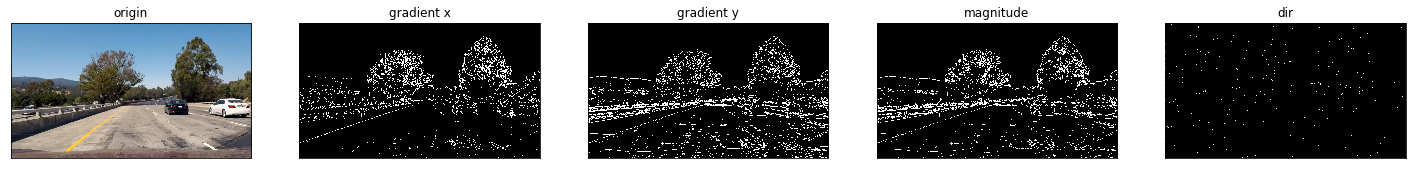

Transformation to color space type: hls_s


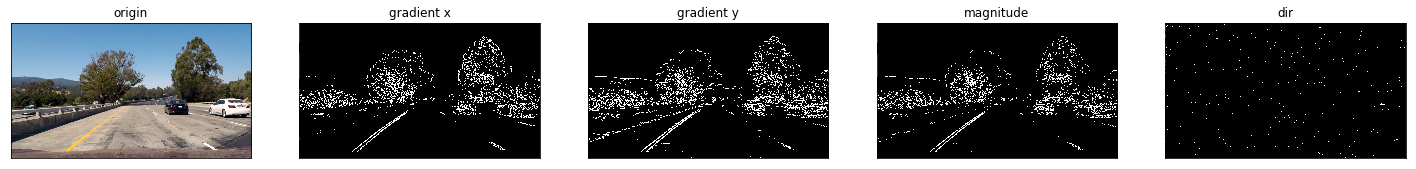

Combined gradient thresholds vs. hls s channel


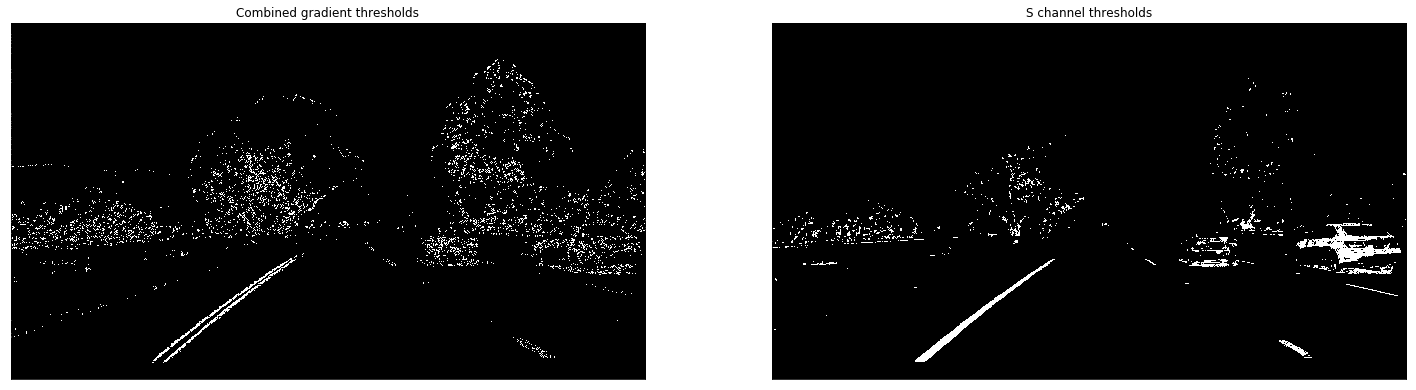

Combined using hls s channel


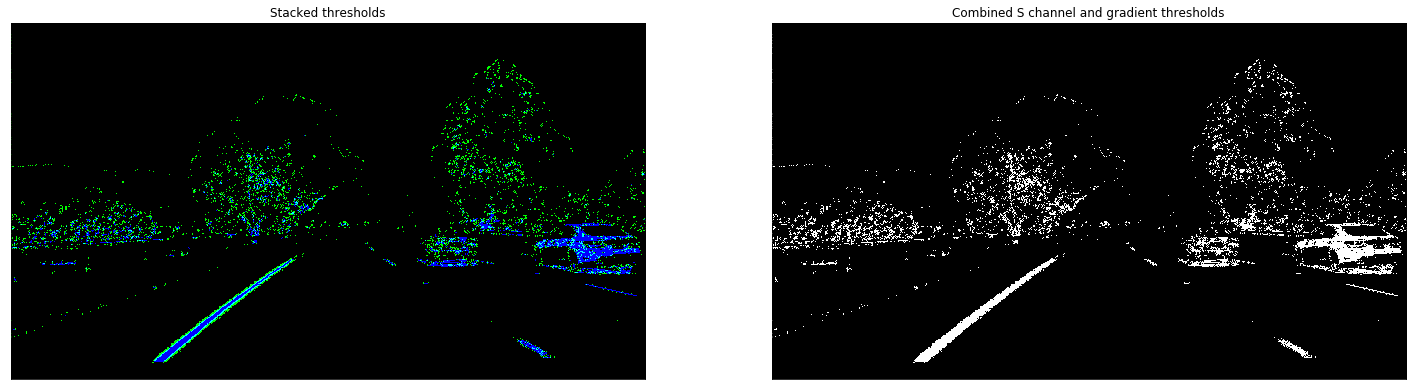

In [7]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

image = mpimg.imread('test_images/test1.jpg')

transformation_types = ['gray', 'hls_s']

for tf_type in transformation_types:
    transform = ImageTransformation(tf_type)
    print('Transformation to color space type: ' + tf_type)
    
    # Apply each of the thresholding functions
    gradx = transform.abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = transform.abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = transform.mag_thresh(image, sobel_kernel=ksize, thresh=(30, 100))
    dir_binary = transform.dir_threshold(image, sobel_kernel=9, thresh=(0, np.pi/2))

    plt.figure(figsize=(25,15))
    plt.subplot(151), plt.imshow(image)
    plt.title("origin"), plt.xticks([]), plt.yticks([])
    plt.subplot(152), plt.imshow(gradx, cmap='gray')
    plt.title("gradient x"), plt.xticks([]), plt.yticks([])
    plt.subplot(153), plt.imshow(grady, cmap='gray')
    plt.title("gradient y"), plt.xticks([]), plt.yticks([])
    plt.subplot(154), plt.imshow(mag_binary, cmap='gray')
    plt.title("magnitude"), plt.xticks([]), plt.yticks([])
    plt.subplot(155), plt.imshow(dir_binary, cmap='gray')
    plt.title("dir"), plt.xticks([]), plt.yticks([])

    plt.show()
    
#------------------------------------------
print('Combined gradient thresholds vs. hls s channel')
transform = ImageTransformation('hls_s')
img = mpimg.imread('test_images/test1.jpg')

gradient_thresh = transform.gradient_thresh(img)
color_thresh = transform.color_thresh(img)

plt.figure(figsize=(25,15))
plt.subplot(121), plt.imshow(gradient_thresh, cmap='gray')
plt.title('Combined gradient thresholds'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(color_thresh, cmap='gray')
plt.title('S channel thresholds'), plt.xticks([]), plt.yticks([])
plt.show()

print('Combined using hls s channel')
combined_stacked = transform.combined_stacked(image)
combined_binary = transform.combined_binary(image)

plt.figure(figsize=(25,15))
plt.subplot(121), plt.imshow(combined_stacked)
plt.title('Stacked thresholds'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(combined_binary, cmap='gray')
plt.title('Combined S channel and gradient thresholds'), plt.xticks([]), plt.yticks([])

plt.show()



### Apply a perspective transform to rectify binary image ("birds-eye view").

The perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform you’ll be most interested in is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. Aside from creating a bird’s eye view representation of an image, a perspective transform can also be used for all kinds of different view points.

Compute the perspective transform, M, given source and destination points:

`M = cv2.getPerspectiveTransform(src, dst)`

Compute the inverse perspective transform:

`Minv = cv2.getPerspectiveTransform(dst, src)`

Warp an image using the perspective transform, M:

`warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)`


In [8]:
def perspective_transform(image):
    height = image.shape[0]
    width = image.shape[1]
    # Src Image quadrangle verties coordinates 
    src = np.float32([[280,  700],  # Bottom left
                      [595,  460],  # Top left
                      [725,  460],  # Top right
                      [1125, 700]]) # Bottom right
    
    # Dst Image quadrangle verties coordinates
    dst = np.float32([[250,  720],  # Bottom left
                      [250,    0],  # Top left
                      [1065,   0],  # Top right
                      [1065, 720]]) # Bottom right 
    
    # Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transform (to unwarp)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(image, M, (width, height), flags=cv2.INTER_LINEAR)
    
    # Return the resulting image
    return warped, M, Minv

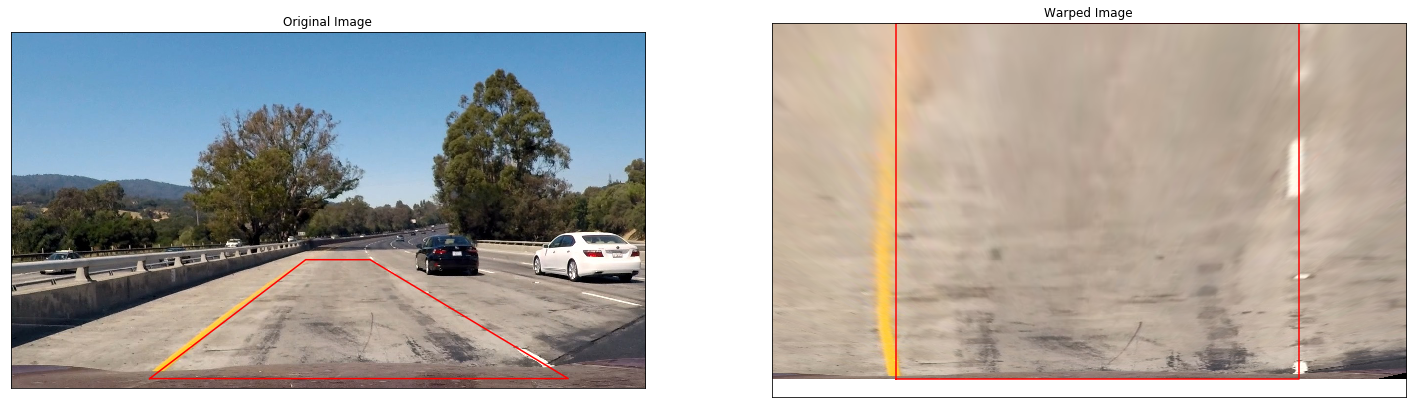

In [9]:
image = mpimg.imread('test_images/test1.jpg')
warped_image, M, Minv = perspective_transform(image) 

height = image.shape[0]
width = image.shape[1]
# Src Image quadrangle verties coordinates 
src = np.float32([[280,  700],  # Bottom left
                  [595,  460],  # Top left
                  [725,  460],  # Top right
                  [1125, 700]]) # Bottom right

# Dst Image quadrangle verties coordinates
dst = np.float32([[250,  720],  # Bottom left
                  [250,    0],  # Top left
                  [1065,   0],  # Top right
                  [1065, 720]]) # Bottom right 

plt.figure(figsize=(25,15))
plt.subplot(121), plt.imshow(image), plt.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(warped_image), plt.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
plt.title('Warped Image'), plt.xticks([]), plt.yticks([])

plt.show()

### Detect lane pixels and fit to find the lane boundary.

In [10]:
# Get Histogram for bottom half of the image (close to car)
def get_histogram(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)


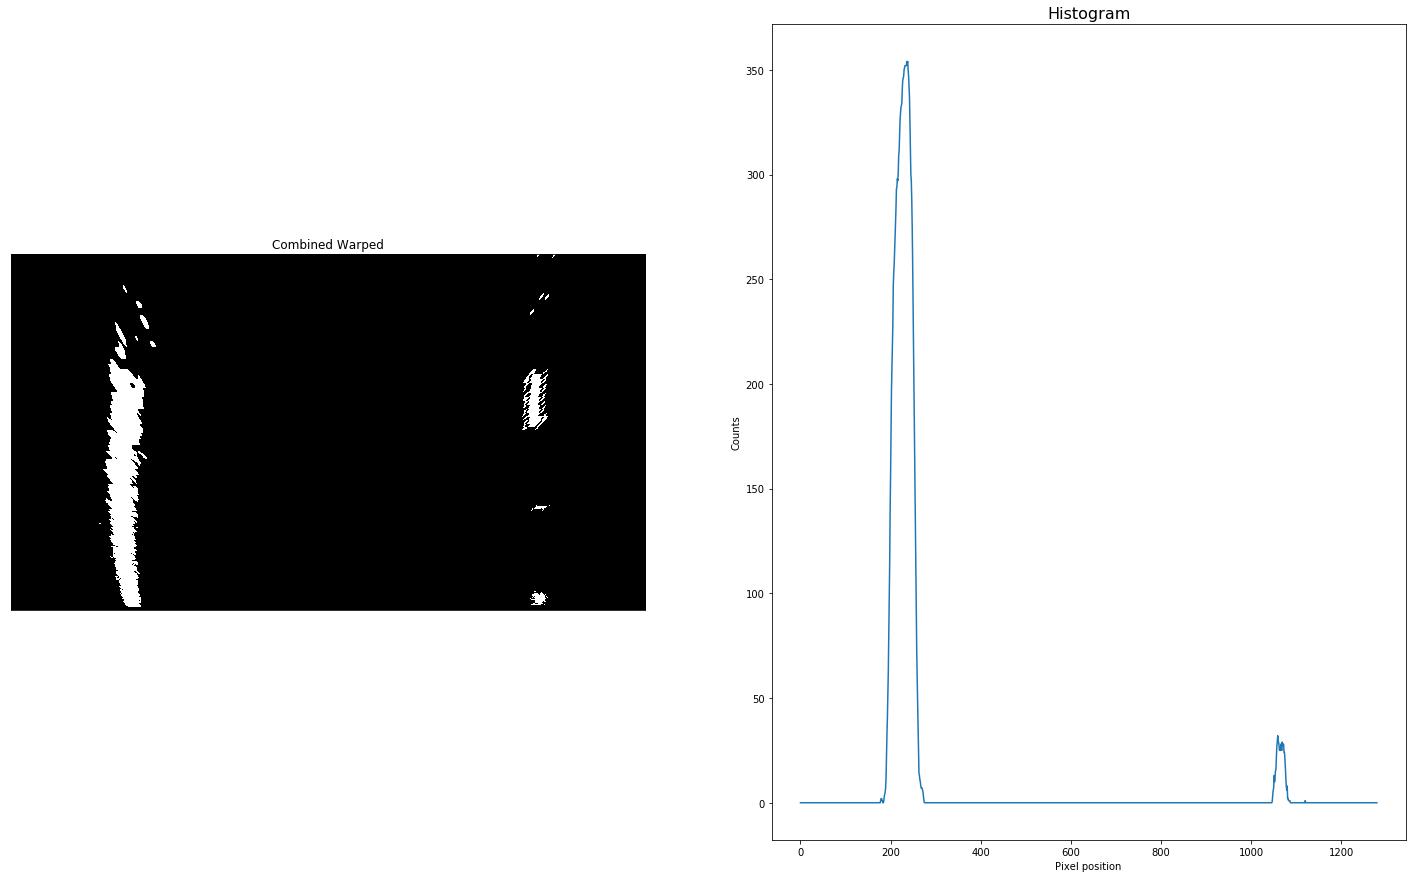

In [11]:
# Run de function over the combined warped image
combined_warped, M, Minv = perspective_transform(combined_binary)
histogram = get_histogram(combined_warped)

plt.figure(figsize=(25,15))
plt.subplot(121), plt.imshow(combined_warped, cmap='gray')
plt.title('Combined Warped'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.plot(histogram)
plt.title('Histogram', fontsize=16), plt.xlabel('Pixel position'), plt.ylabel('Counts')

plt.show()

### Sliding Window

With this histogram we are adding up the pixel values along each column in the image. In our thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. We can use that as a starting point for where to search for the lines. From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

In [12]:
def find_poly(binary_warped, return_img=False):
    # --------------------------------------------------------
    # FROM HERE: This part finds the lane pixels
    # --------------------------------------------------------

    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
    # Take a histogram of the bottom half of the image
    histogram =  get_histogram(binary_warped)
        
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # --------------------------------------------------------
    # If divided into two seperate functions
    # return leftx, lefty, rightx, righty, out_img
    #
    # FROM HERE: This part fits the polynomial
    # --------------------------------------------------------

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    if return_img:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(binary_warped.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

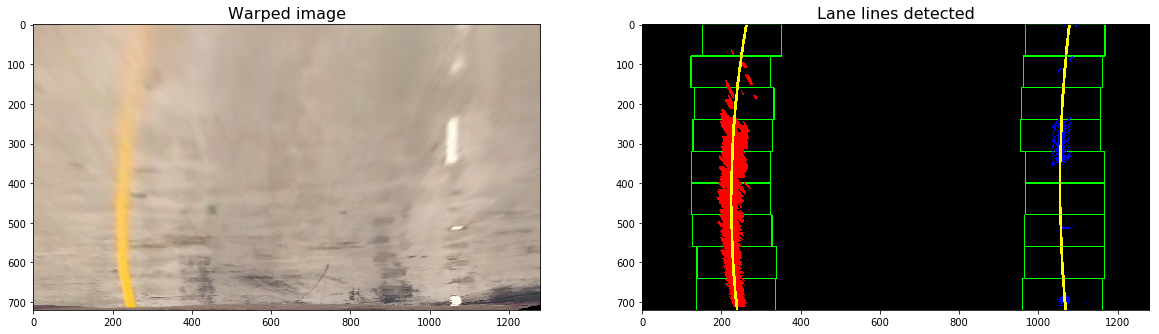

In [13]:
# Run the function
lines_fit, left_points, right_points, out_img = find_poly(combined_warped, return_img=True)

# Plot the results
plt_images(warped_image, 'Warped image', out_img, 'Lane lines detected')

### Skip the sliding windows step once you've found the lines

In the next frame of video we don't need to do a blind search again, but instead you can just search in a margin around the previous lane line position, like in the above image. The green shaded area shows where we searched for the lines this time. So, once we know where the lines are in one frame of video, we can do a highly targeted search for them in the next frame.

This is equivalent to using a customized region of interest for each frame of video, and should help you track the lanes through sharp curves and tricky conditions. If you lose track of the lines, go back to your sliding windows search or other method to rediscover them.

#### Use the previous polynomial to skip the sliding window

In the previous quiz, we used `left_lane_inds` and `right_lane_inds` to hold the pixel values contained within the boundaries of a given sliding window. This time, we'll take the polynomial functions we fit before (`left_fit` and `right_fit`), along with a hyperparameter `margin`, to determine which activated pixels fall into the green shaded areas from the above image. Note that this `margin` can be a different value than the one originally used for your sliding windows!

To implement this in the below quiz, you'll want to grab only those pixels with x-values that are +/- your `margin` from your polynomial lines. Note that you'll only need to implement `left_lane_inds` and `right_lane_inds` in the quiz - most of the surrounding code, ignoring iterating through the windows, is the same as before!

The way we'll visualize this is a bit different than last time around, however, so make sure to pay attention to that if you want to visualize this step while working on your project.

In [14]:
def search_around_poly(binary_warped, line_fits=None, return_img=False):
    # If no previous lane detected use window search
    if line_fits is None:
        return find_poly(binary_warped, return_img)
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 150
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If no line could be found go back to window search
    if (leftx.size <= 1 or rightx.size <= 1):
        return find_poly(binary_warped, return_img)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        for index in range(binary_warped.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
        ## End visualization steps ##
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)


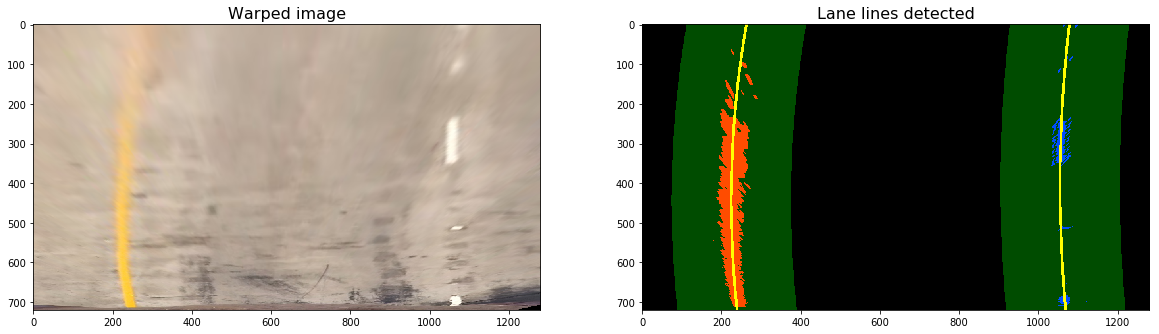

In [15]:
# Run image through the pipeline
lines_fit, left_points, right_points, out_img = search_around_poly(combined_warped, lines_fit, return_img=True)

# Plot the results
plt_images(warped_image, 'Warped image', out_img, 'Lane lines detected')

### Determine the curvature of the lane and vehicle position with respect to center.

In [16]:
def measure_curvature(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    '''
    Calculate Position of the car relative to the lane center
    '''    
    ## Image mid horizontal position 
    img_mid_x = img_shape[1]//2
        
    ## Position in lane
    pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal offset 
    offset_x = (img_mid_x - pos) * xm_per_pix

    return offset_x


In [17]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 25/720 # meters per pixel in y dimension
xm_per_pix = 3.7/800 # meters per pixel in x dimension

# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature(left_points[1], lines_fit[0], lines_fit[1])

# Calculate Position of the car relative to the lane center
offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=combined_warped.shape)

# Print the results
print('Left line curvature:', left_curverad, 'm')
print('Right line curvature:', right_curverad, 'm')
print ('Car offset from center:', offsetx, 'm.')

Left line curvature: 2624.01336456 m
Right line curvature: 3520.52086615 m
Car offset from center: -0.0636277357231 m.


### Warp the detected lane boundaries back onto the original image.

In [18]:

def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

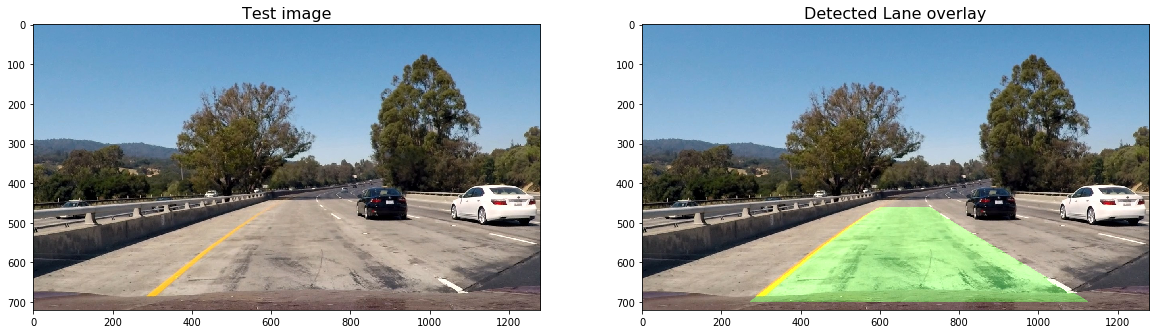

In [19]:
# Run the function
image_lane_overlay = draw_lane(image, combined_warped, left_points, right_points, Minv)

# Plot the results
plt_images(image, 'Test image', image_lane_overlay, 'Detected Lane overlay')

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [20]:
def metrics_overlay(img, left_curverad, right_curverad, offsetx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(left_curverad), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(right_curverad), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

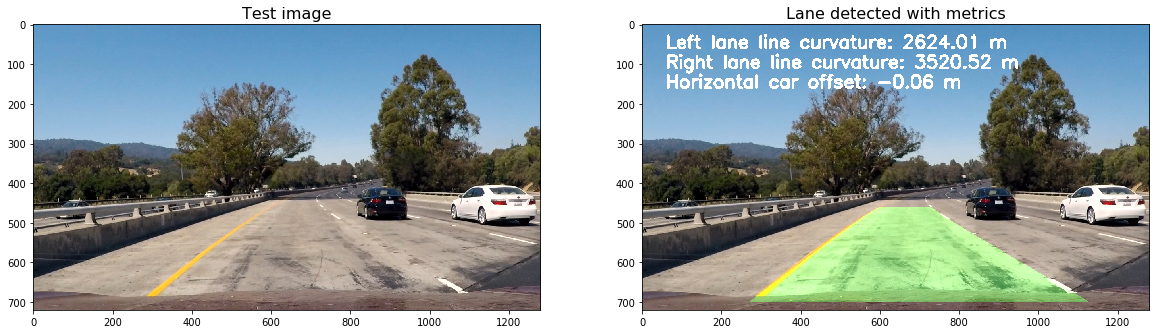

In [21]:
# Run the function
out_img = metrics_overlay(image_lane_overlay, left_curverad, right_curverad, offsetx)

# Plot the results
plt_images(image, 'Test image', out_img, 'Lane detected with metrics')

## Pipeline

In [22]:
class LaneFinding:
    def __init__(self):
        # Initialize Camera Object
        print('Initialize Camera Object')
        self.camera = Camera()
        
        # Calibrate Camera
        print('Calibrate Camera')
        self.camera.calibrate(glob.glob('camera_cal/*'), pattern_size=(9,6))
        print('Calibration Done!')
        
        # Choose a Sobel kernel size
        self.ksize = 3 # Choose a larger odd number to smooth gradient measurements

        # Initialize Image transformation
        self.transform = ImageTransformation('hls_s')
        
        # Initialize Lane fits
        self.lanes_fit = None

    def __call__(self, img):
        
        # Undistort image
        undistorted_img = self.camera(img)
        
        # Apply thresholding functions
        combined_binary = self.transform.combined_binary(undistorted_img)
        
        # Transform perspective over the combined warped image
        combined_warped_image, M, Minv = perspective_transform(combined_binary) 
        
        # Get lane lines
        self.lanes_fit, left_points, right_points = find_poly(combined_warped_image)

        # Get lane lines
        # self.lanes_fit, left_points, right_points = search_around_poly(combined_warped_image, self.lanes_fit)
        
        # Calculate the radius of curvature in pixels for both lane lines
        left_curverad, right_curverad = measure_curvature(left_points[1], self.lanes_fit[0], self.lanes_fit[1])

        # Calculate Position of the car relative to the lane center
        offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=combined_warped_image.shape)
        
        
        image_lane_overlay = draw_lane(img, combined_warped_image, left_points, right_points, Minv)

        # Add metrics to the output img
        out_img = metrics_overlay(image_lane_overlay, left_curverad, right_curverad, offsetx)
            
        return out_img

## Video

In [23]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(20,30)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
lane_finding = LaneFinding()

white_clip = clip1.fl_image(lane_finding)

%time white_clip.write_videofile(output_video, audio=False)

Initialize Camera Object
Calibrate Camera
Calibration Done!
[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


100%|█████████▉| 1260/1261 [09:29<00:00,  2.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 5min 3s, sys: 2min 23s, total: 7min 27s
Wall time: 9min 32s


In [24]:
output_video = './project_video_solution.mp4'

HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))